In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
import plotly.express as px 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline



Criando o dicionário sobre os dados disnponiveis 
(
    CRIM: Taxa de criminalidade per capita por cidade
    ZN: proportção de hectares de negócios não-varejo por cidade
    INDUS: Proporção de hectares de negócios não-varejo por cidade
    CHAS: variável ficticia do rio charles (1 se o tract se delimita caso não 0)
    NOX: Concentração de óxido nitrico
    RM: Número médio de quartos por habitação
    AGE: Proporção de unidades coupadas pelo proprietário construidas antes de 1940
    DIS: Indice de acessibilidade a rodovias radiais
    TAX: Taxa de imposto de propriedade de valor total por US $ 10.000
    PTRATIO: relação aluno-altafegado por cidade
    B: O resultado da equação B-1000(Bk - 0,63) onde Bk é a proporção de negros por cidade
    LSTAT: % inferior ao status da população

MEDV: Valor médio da
)

In [2]:
house = pd.read_csv('boston.csv', sep =',')
print('Informações gerais dos dados')
print(house.info())
print('Descrição Geral dos dados')
print(house.describe())

Informações gerais dos dados
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
Descrição Geral dos dados
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.61

In [3]:
import matplotlib.pyplot as plt 
# plotando alguns gráficos para melhorar o entendimento dos dados
# Histogramas

hist = px.histogram(house, x='MEDV', nbins=50, title='Distribuição entre a média de vendas')
hist.show()

fig1 = px.scatter_matrix(house, dimensions = ['CRIM', 'B', 'TAX', 'MEDV'])
fig1.show()

fig_tax = px.scatter(house, x ='MEDV', y= 'TAX', title ='Impostos VS Preço')
fig_tax.show()

tax = px.scatter(house, x = 'RM', y= 'MEDV', title = 'Média de quartos por preço de venda')
tax.show()

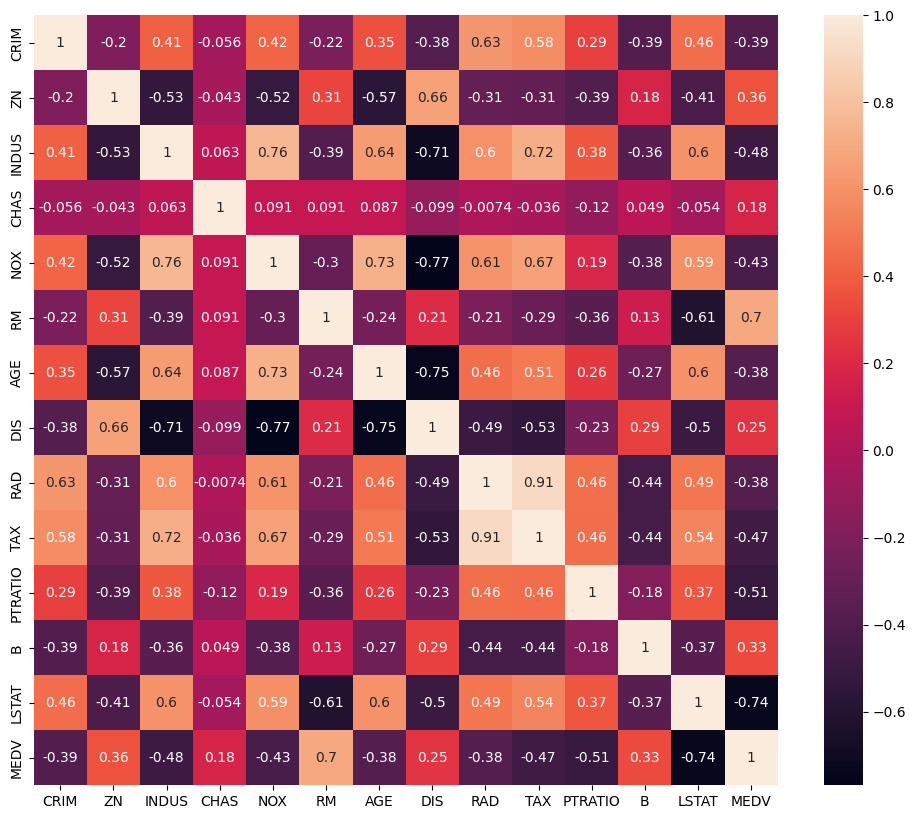

In [4]:
import seaborn as sns 
plt.figure(figsize=(12,10))
sns.heatmap(house.corr(), annot = True)
plt.show()

Para meu modelo vou adotar duas abordagens uma vou usar o random searchcv
e na segunda vou usar o grid search cv para treinar e comparar meus modelos.

## Primeira etapa 

In [5]:
# Instanciando os modelos
linear = LinearRegression()
svr = LinearSVR(random_state=42, dual=True)
knn = KNeighborsRegressor(n_neighbors=5)
tree = DecisionTreeRegressor()

# Separando os dados em treino e teste
x = house.drop('MEDV', axis=1)
y = house['MEDV']

x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.12, random_state=42)

# Criando as pipelines para meus modelos
# Linear Regression

pipeline_linear = Pipeline([
    ('scalar', StandardScaler()),
    ('linear_model', LinearRegression())
])


# K-neighbors
pipeline_knr = Pipeline([
    ('scalar', StandardScaler()),
    ('knn_model', KNeighborsRegressor())
])
# Linear SVR
pipeline_svr = Pipeline([
    ('scalar', StandardScaler()),
    ('svr_model', LinearSVR(dual = True))
])

#Decision Tree
pipeline_tree = Pipeline([
    ('scalar', StandardScaler()),
    ('tree_model', DecisionTreeRegressor())
])

# Definindo os paramentos para o random search CV

# Linear Regression
linear_params = {
    'linear_model__fit_intercept': [True, False],
    'linear_model__positive': [True, False],
    'linear_model__n_jobs': [1,5,7,14,6]}

#svr
svr_params = {
    'svr_model__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive'],
    'svr_model__intercept_scaling': [1.0, 2.0, 2.5, 3.0],
    'svr_model__max_iter': [1100,2100,3200,4200],
    'svr_model__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive'],
    
    
    }

#Decision tree
grid_tree_params = {
    'tree_model__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    'tree_model__splitter': ['best', 'random'], 
    'tree_model__max_features': [5,7,9,10,12,13],
}

# Knn 
knn_params = {
    'knn_model__n_neighbors': [3, 5, 7, 9, 11, 13],
    'knn_model__n_jobs': [1,2, 4, 8, 12, 16, 20],
    'knn_model__weights': ['uniform', 'distance'],
    'knn_model__p': [1,2]
}



In [6]:
# Começando o Random Search CV

# Linear Regression
random_linear_cv = RandomizedSearchCV(
    estimator = pipeline_linear,
    param_distributions= linear_params,
    n_jobs= -1,
    scoring = 'neg_mean_squared_error',
    random_state=42,
    cv = 15
)

# Linear SVR
random_svr_cv = RandomizedSearchCV(
    estimator = pipeline_svr,
    param_distributions= svr_params,
    n_jobs=30,
    scoring = 'neg_mean_squared_error',
    random_state=42,
    cv = 15
)

# Knn Regressor
random_knr_cv = RandomizedSearchCV(
    estimator = pipeline_knr,
    param_distributions = knn_params,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    cv = 15,
    verbose=1
)

# Decision Tree Regressor

random_tree_cv = RandomizedSearchCV(
    estimator = pipeline_tree,
    param_distributions = grid_tree_params,
    n_jobs = -1,
    scoring = 'neg_mean_squared_error',
    random_state=42,
    cv = 15,
    verbose=1
)

# Começando a busca para cada um dos meus modelos
random_linear_cv.fit(x_train, y_train)
random_knr_cv.fit(x_train, y_train)
random_svr_cv.fit(x_train, y_train)
random_tree_cv.fit(x_train, y_train)



Fitting 15 folds for each of 10 candidates, totalling 150 fits
Fitting 15 folds for each of 10 candidates, totalling 150 fits


RandomizedSearchCV(cv=15,
                   estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                             ('tree_model',
                                              DecisionTreeRegressor())]),
                   n_jobs=-1,
                   param_distributions={'tree_model__criterion': ['squared_error',
                                                                  'friedman_mse',
                                                                  'poisson',
                                                                  'absolute_error'],
                                        'tree_model__max_features': [5, 7, 9,
                                                                     10, 12,
                                                                     13],
                                        'tree_model__splitter': ['best',
                                                                 'random']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [7]:
# Pegando os melhores modelos
random_best_model_linear = random_linear_cv.best_estimator_
random_best_model_knr = random_knr_cv.best_estimator_ 
random_best_model_svr = random_svr_cv.best_estimator_ 
random_best_model_tree = random_tree_cv.best_estimator_ 

print(f'Melhores parâmetros para a regressão linear:\n {random_linear_cv.best_params_}')
print()
print(f'Melhores parâmetros para a KNN:\n {random_knr_cv.best_params_}')
print()
print(f'Melhores parâmetros para a Linear SVR:\n {random_svr_cv.best_params_}')
print()
print(f'Melhores parâmetros para a árvore de decisão:\n {random_tree_cv.best_params_}')



Melhores parâmetros para a regressão linear:
 {'linear_model__positive': False, 'linear_model__n_jobs': 1, 'linear_model__fit_intercept': True}

Melhores parâmetros para a KNN:
 {'knn_model__weights': 'distance', 'knn_model__p': 2, 'knn_model__n_neighbors': 3, 'knn_model__n_jobs': 4}

Melhores parâmetros para a Linear SVR:
 {'svr_model__max_iter': 2100, 'svr_model__loss': 'squared_epsilon_insensitive', 'svr_model__intercept_scaling': 3.0}

Melhores parâmetros para a árvore de decisão:
 {'tree_model__splitter': 'best', 'tree_model__max_features': 9, 'tree_model__criterion': 'squared_error'}


Com a pesquisa aleatoria feita antes de avaliar os modelos vou fazer o grid search

In [8]:
# Começando o GridSearch
grid_tree = GridSearchCV(
    estimator = pipeline_tree,
    param_grid= grid_tree_params,
    verbose = 1,
    n_jobs= -1,
    cv = 15
)

grid_linear = GridSearchCV(
    estimator = pipeline_linear,
    param_grid= linear_params,
    verbose = 1,
    n_jobs= -1,
    cv = 15
)

grid_knn = GridSearchCV(
    estimator = pipeline_knr,
    param_grid= knn_params,
    verbose = 1,
    n_jobs= -1,
    cv = 15
)

grid_svr = GridSearchCV(
    estimator = pipeline_svr,
    param_grid= svr_params,
    verbose = 1,
    n_jobs= -1,
    cv = 15
)

grid_svr.fit(x_train, y_train)
grid_tree.fit(x_train, y_train)
grid_knn.fit(x_train, y_train)
grid_linear.fit(x_train, y_train)


Fitting 15 folds for each of 32 candidates, totalling 480 fits
Fitting 15 folds for each of 48 candidates, totalling 720 fits
Fitting 15 folds for each of 168 candidates, totalling 2520 fits


c:\Users\cassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



Fitting 15 folds for each of 20 candidates, totalling 300 fits


GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('linear_model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'linear_model__fit_intercept': [True, False],
                         'linear_model__n_jobs': [1, 5, 7, 14, 6],
                         'linear_model__positive': [True, False]},
             verbose=1)

Com ambas pesquisas feitas agora vou fazer a previsão com cada um dos modelos e depois compara-los para saber qual se desempenhou melhor com meus dados.

In [14]:
# Pegando os melhores modelos do grid Search
grid_linear_best_model = grid_linear.best_estimator_
grid_knn_best_model = grid_knn.best_estimator_
grid_svr_best_model = grid_svr.best_estimator_
grid_tree_best_model = grid_tree.best_estimator_ 

# Previsão com os melhores modelos da pesquisa aleatoria
y_r_linear = random_best_model_linear.predict(x_test)
y_r_knn = random_best_model_knr.predict(x_test)
y_r_svr = random_best_model_svr.predict(x_test)
y_r_tree = random_best_model_tree.predict(x_test)

# Preivsão com as melhores modelos do grid search
y_g_linear = grid_linear_best_model.predict(x_test)
y_g_knn = grid_knn_best_model.predict(x_test)
y_g_svr = grid_svr_best_model.predict(x_test)
y_g_tree = grid_tree_best_model.predict(x_test)



In [20]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
print(mean_absolute_error(y_test, y_r_linear))
print(r2_score(y_test, y_r_linear))
print(root_mean_squared_error(y_test,y_r_linear))
print(mean_squared_error(y_test,y_r_linear))


2.733225107438184
0.7897494735318473
3.7193953168092744
13.833901522702762
